# Training (changing dataset class)

## Set up

### Package imports

In [1]:
# Import packages
import re
import os
import gc
import copy
from pathlib import Path
import numpy as np
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
import pandas as pd
import math
import random
import datetime
import time
import warnings
from pdb import set_trace
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, Sampler
from torchvision import models, transforms

### GPU

In [2]:
# Check to see if the GPU is available and store it as a variable so tensors can be moved to it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print('Is cuda available?:', torch.cuda.is_available())
print('cuda version:', torch.version.cuda)
dev = "cuda:0"

Using device: cuda
Is cuda available?: True
cuda version: 12.4


### Variables and Hyperparameters

In [3]:
# Create a timestamp for the summary file name
Time_Stamp = datetime.datetime.now().strftime("%Y_%m%d%_H%M")

# Create run name
Run_Name = '0420; protein + mRNA; PixelPreserve; focal; gamma2' # change run_name before running

# Paths
raw_folder_path = '/home/ec2-user/Feb2025/raw_datasets/' # raw dataset folder with all the proteome and mRNA data
label_path = '/home/ec2-user/Feb2025/labels/' # label folder with all the labels
dataset_folder_path = '/home/ec2-user/Feb2025/processed_dataset2/' # dataset folder with all the processed proteome and mRNA data
model_folder_path = '/home/ec2-user/Feb2025/saved_models/' # model folder with all the models
# Define the Model
Model = 'PixelPreserve' # 'ResNet18', 'CustomNN-reg', 'CustomNN-stride2', and 'PixelPreserve' are the options

# Define loss function
LossFunc_Name = 'Focal' # 'CrossEntropy', 'Focal' are the options

# Define the optimizer
Optim_Name = 'AdamW' # 'Adam', 'AdamW', 'SGD', 'SGD_weight' are the options

# Dataset
Set = 'Protein + mRNA' # Define the dataset to use, 'Protein', 'mRNA', or 'Protein + mRNA' are the options

# Image size
if Set == 'Protein + mRNA':
    Canvas_Size = 18 # 13x13 for protein/mRNA, 18x18 for protein+mRNA
else:
    Canvas_Size = 18

# Seed number
Seed = 43

# Validation fraction
Validation_Fraction = 0.15

# Standard deviation for add-noise transformation
StandardDeviation = 0.005

# Learning rate scheduler
LrScheduler = True
Learner_rate = 1e-4

# Optimizer
Weight_Decay = 0.0001 # L2 regulator
#  it works by adding a penalty to the loss function, which discourages large weights in the model; penalizes for too many weights - helps prevent overfitting
#  the penalty is calculated as weight_decay * weight^2, and it's added to the loss.
#  1e-4 or 1e-3 gives higher acc

# Loss Function (CrossEntropyLoss)
Label_Smoothing = 0.1
#  sets the target of the loss function to something greater than 0 and less than 1
#  helps prevent overfitting

# Transformation
TransformOrNot = True

# Class weight to loss function
ApplyClassWeightToLoss = True
#  makes the loss weights equal to the fraction of each category label
#  note, a layer is added to the model so the outputs of the model are equal to the number of categories

# Batch size
batch = 64

# Epoch amount
epochs = 50

### Protein, mRNA dataframe, localization label set up

In [4]:
# Open the proteomics data and only keep genes (rows) that are fully quantified
PFP = 'K_PD_synthetic_kde_qttumor.csv' # synthetic data
PD = pd.read_csv(dataset_folder_path+PFP)

# Data set wrangling
PD.index = PD.loc[:,'Index']
PD = PD.loc[:,PD.columns!='Index']
PD.dropna(inplace=True)

# Open the mRNA data and only keep genes (rows) that are fully quantified
MFP = 'K_MD_synthetic_kde_qttumor.csv'
MD = pd.read_csv(dataset_folder_path + MFP)

# Data set wrangling
MD.index = MD.loc[:,'Index']
MD = MD.loc[:,MD.columns!='Index']
MD = MD.drop_duplicates()
MD.dropna(inplace=True)

In [5]:
# Open the labels data
LFP = 'markers_mcf7_all.txt'
LD = pd.read_csv(filepath_or_buffer=label_path+LFP,sep='\t')
# Data set wrangling
LD.index = LD.loc[:,'Protein']
LD = LD.loc[:,LD.columns!='Protein']

In [6]:
# Select the localization labels that are both common in the proteomics and mRNA data
common_genes = set(PD.index).intersection(set(MD.index))
# Select only the common genes
LD = LD.loc[LD.index.isin(common_genes),:]

print('Number of total labels in Krug dataset')
print(len(LD.index))
print(LD['Localization'].value_counts())

Number of total labels in Krug dataset
6444
Localization
Cytosol         2825
Nucleus         1828
Secretory       1308
Mitochondria     483
Name: count, dtype: int64


### Set seed function

In [7]:
def set_seed(seed):
    random.seed(seed) # set random seed for python
    np.random.seed(seed) # set random seed for numpy
    torch.manual_seed(seed) # set random seed for CPU
    rs = RandomState(MT19937(SeedSequence(seed))) # seed for numpy
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed) # set random seed for all GPUs
    torch.backends.cudnn.deterministic = True # set to True to get reproducible results
    torch.backends.cudnn.benchmark = False # set to False to get reproducible results

### Canvas and RGB tensor generation functions

In [8]:
def interleave_arrays(set=None, df1=None, df2=None):
    """
    Interleave the values from abundance arrays if using both datasets.
    
    Parameters:
    set (str): Dataset used for plotting ('Protein', 'mRNA', 'Protein + mRNA').
    df1 (pd.DataFrame): First array containing normalized abundance data.
    df2 (pd.DataFrame): Second array containing normalized abundance data.
    
    Returns:
    np.array: Interleaved array of df1 and df2 values if both are provided, otherwise sorted df1 or df2 array.
    """
    def sort_and_interleave(df1, df2=None):
        # Convert DataFrames to arrays
        df1_array = df1.values if isinstance(df1, pd.DataFrame) else df1
        df2_array = df2.values if isinstance(df2, pd.DataFrame) else df2

        # Ensure df1 and df2 have compatible shapes
        assert df1_array.shape == df2_array.shape if df2_array is not None else True, \
            "df1 and df2 must have the same shape if both are provided."

        # Compute the sum for sorting if df2 is provided, otherwise just use df1
        sum_abundance = df1_array + (df2_array if df2_array is not None else 0)

        # Sort indices by sum_abundance for each row
        sorted_indices = np.argsort(sum_abundance, axis=1)  # Ascending order

        # Sort df1 and df2 based on sorted indices
        try:
            df1_sorted = np.take_along_axis(df1_array, sorted_indices, axis=1)
            if df2_array is not None:
                df2_sorted = np.take_along_axis(df2_array, sorted_indices, axis=1)
                return df1_sorted, df2_sorted
            else:
                return df1_sorted, None
        except IndexError as e:
            print("IndexError in sort_and_interleave:")
            print(f"df1_array shape: {df1_array.shape}, df2_array shape: {df2_array.shape if df2_array is not None else 'None'}")
            print(f"sorted_indices shape: {sorted_indices.shape}")
            raise e

    if set == 'Protein + mRNA' or set == 'Protein' or set == 'mRNA':
        assert df1.shape == df2.shape, "df1 and df2 dataframes must have the same shape."
        df1_sorted, df2_sorted = sort_and_interleave(df1, df2)
        
        interleaved_array = np.empty((len(df1_sorted), Canvas_Size*Canvas_Size), dtype=df1_sorted.dtype)
        interleaved_array[:, 0::2] = df1_sorted
        interleaved_array[:, 1::2] = df2_sorted
        return interleaved_array
    
    else:
        raise ValueError("Set must be 'Protein', 'mRNA', or 'Protein + mRNA'")

def gen_horizontal_coords(n, num_points):
    """
    Generate coordinates for a horizontal pattern starting from the top-left corner.

    Parameters:
    n (int): Size of the canvas (n x n).
    num_points (int): Number of points to generate in the horizontal pattern.

    Returns:
    list: List of (x, y) coordinates in horizontal order.
    """
    coords = [(x, y) for x in range(n) for y in range(n)]
    return coords[:num_points]

def create_rgb_tensors(set, df1, df2):
    """
    Create RGB tensors from abundance data using the specified pattern.
    
    Parameters:
    set (str): Dataset used for plotting ('Protein', 'mRNA', 'Protein + mRNA').
    df1 (pd.DataFrame): DataFrame containing normalized abundance data.
    df2 (pd.DataFrame): DataFrame containing normalized abundance data.
    
    Returns:
    torch.Tensor: RGB tensor.
    """

    final_array = interleave_arrays(set, df1, df2)
    final_array = final_array.flatten()
    num_pixels = len(final_array)
    
    # Generate coordinates based on the pattern, spiral or horizontal arrangment
    coords = gen_horizontal_coords(Canvas_Size, num_pixels)

    # Create RGB tensor
    rgb_tensor = np.zeros((Canvas_Size, Canvas_Size, 3), dtype=np.float32)
    for i, (x, y) in enumerate(coords):
        if i < len(final_array):
            value = final_array[i]
            # Assign colors based on the value, if abundance > 1, set it to red, if abundance < 0, set it to blue.
            if value > 1:
                rgb_tensor[x, y] = [255, 0, 0]  # Red for value > 1
            elif value < 0:
                rgb_tensor[x, y] = [0, 0, 255]  # Blue for value < 0
            else:
                rgb_tensor[x, y] = [255 * value, 0, 255 * (1 - value)]

    return torch.from_numpy(rgb_tensor.transpose(2, 0, 1))  # Convert to CHW format for PyTorch

### Transformation class

In [9]:
class NoiseTransform:
    """
    A class that applies normal noise transformation to a DataFrame.

    Args:
        mean (float): The mean of the normal distribution. Default is 0.
        std_dev (float): The standard deviation of the normal distribution. Default is 0.2.
    """

    def __init__(self, mean=0, std_dev=StandardDeviation):
        super(NoiseTransform, self).__init__()
        self.mean = mean
        self.std_dev = std_dev

    def forward(self, df):
        """
        Applies normal noise transformation to the input DataFrame.

        Args:
            df (pd.DataFrame): The input DataFrame.

        Returns:
            pd.DataFrame: The transformed DataFrame with normal noise applied.
        """
        tensor = torch.from_numpy(df.values).float()
        noise = torch.empty(tensor.size()).normal_(self.mean, self.std_dev)
        noisy_tensor = tensor + noise
        
        # Convert the tensor back to DataFrame
        df_transformed = pd.DataFrame(noisy_tensor.numpy(), index=df.index, columns=df.columns)
        
        return df_transformed

In [10]:
class CombinedTransform:
    """
    A class representing a combined transformation.

    Args:
        set: The dataset used for the transformation.
        transform1: The first transformation to apply.
        transform2: The second transformation to apply (optional).
        FeatureEngineering: Whether to use the feature engineering data.

    Attributes:
        transform1: The first transformation.
        transform2: The second transformation.
        FeatureEngineering: Whether to use the feature engineering data.

    Methods:
        __call__: Applies the combined transformation to the input dataframes.

    """

    def __init__(self, set, transform1=None, transform2=None):
        self.set = set
        self.transform1 = transform1 if transform1 is not None else None
        self.transform2 = transform2 if transform2 is not None else None

    def __call__(self, set, df1, df2):
        """
        Applies the combined transformation to the input dataframes.

        Args:
            set: The dataset used for the transformation.
            df1: The first dataframe.
            df2: The second dataframe.

        Returns:
            transformed_rgb_tensors: The transformed RGB tensors.

        """

        # apply the first transformation (noise) to df1 and df2; df1 is PD, df2 is MD
        if self.transform1 is not None:
            df1 = self.transform1.forward(df1) if df1 is not None else None
            df2 = self.transform1.forward(df2) if df2 is not None else None
            
        # apply the second transformation (random column) to df1 and df2
        if self.transform2 is not None:
            df1, df2 = self.transform2.forward(df1, df2) if df1 is not None and df2 is not None else (None, None)
        
        # make rgb tensors depending on the set
        if self.set == 'Protein':
            transformed_rgb_tensors = create_rgb_tensors(self.set, df1, df2)
        elif self.set == 'mRNA':
            transformed_rgb_tensors = create_rgb_tensors(self.set, df1, df2)
        elif self.set == 'Protein + mRNA':
            transformed_rgb_tensors = create_rgb_tensors(self.set, df1, df2)
        
        if transformed_rgb_tensors is None:
            raise ValueError("Set must be 'Protein', 'mRNA', or 'Protein + mRNA'")
                
        return transformed_rgb_tensors

### Dataset class

In [11]:
class MyDataset(Dataset):
    def __init__(self, set, df1, df2, labels, transform=None):
        self.set = set
        self.df1 = df1 if df1 is not None else None
        self.df2 = df2 if df2 is not None else None
        self.labels = labels
        self.transform = transform

    def __getitem__(self, idx):
        df1_data = self.df1.iloc[idx].to_frame().T if self.df1 is not None else None
        df2_data = self.df2.iloc[idx].to_frame().T if self.df2 is not None else None
        label = self.labels[idx]

        if self.transform:  
            if self.set == 'Protein + mRNA':
                tensor = self.transform(self.set, df1_data, df2_data)
            elif self.set == 'Protein':
                tensor = self.transform(self.set, df1_data, df1_data)
            elif self.set == 'mRNA':
                tensor = self.transform(self.set, df2_data, df2_data)

        else:
            if self.set == 'Protein + mRNA':
                tensor = create_rgb_tensors(self.set, df1_data, df2_data)
            elif self.set == 'Protein':
                tensor = create_rgb_tensors(self.set, df1_data, df1_data)
            elif self.set == 'mRNA':
                tensor = create_rgb_tensors(self.set, df2_data, df2_data)

        # Ensure tensor is not None
        if tensor is None:
            raise ValueError("Both df1 and df2 are None, cannot create tensor.")

        return tensor, label

    def __len__(self):
        return len(self.labels)

    def get_labels(self):
        return self.labels

## Model training

In [12]:
# Create an instance of the transform
noise_transform = NoiseTransform()

# Create an instance of the combined transform， change here if doing different transformation
# Transform 1 default is noise_transform, transform 2 default is TBD
transform = CombinedTransform(set=Set, transform1=noise_transform, transform2=None)

### Dataloaders

In [13]:
# Set seed to ensure reproducibility
set_seed(Seed)

# Create a LabelEncoder
encoder = LabelEncoder()

# Fit the encoder and transform the labels to integers from LD, the label dataframe
labels = encoder.fit_transform(LD.values.ravel())

# Convert the labels to tensors
labels = torch.tensor(labels)

# Split the data into training and validation sets using the labels indices, random state is set
indices = range(len(labels))
train_indices, val_indices, train_labels, val_labels = train_test_split(indices, labels, test_size=Validation_Fraction, random_state=42)

# Use the indices to split PD and MD
if PFP is not None:
    if Set == 'Protein' or 'Protein + mRNA':
        train_PD = PD.iloc[train_indices]
        val_PD = PD.iloc[val_indices]
        print('Proteome data set is splited')
if MFP is not None:
    if Set == 'mRNA' or 'Protein + mRNA':
        train_MD = MD.iloc[train_indices]
        val_MD = MD.iloc[val_indices]
        print('mRNA data set is splited')

## Create the datasets
# Initialize transform to None
transform_to_use = None

# Check if transformations should be applied
if TransformOrNot:
    transform_to_use = transform # transform is defined above

# Check Dataset argument to determine which dataset to use
if Set == 'Protein':
    train_dataset = MyDataset(Set, train_PD, train_PD, train_labels, transform=transform_to_use)
    val_dataset = MyDataset(Set, val_PD, val_PD, val_labels, transform=None)
elif Set == 'mRNA':
    train_dataset = MyDataset(Set, train_MD, train_MD, train_labels, transform=transform_to_use)
    val_dataset = MyDataset(Set, val_MD, val_MD, val_labels, transform=None)
elif Set == 'Protein + mRNA':
    train_dataset = MyDataset(Set, train_PD, train_MD, train_labels, transform=transform_to_use)
    val_dataset = MyDataset(Set, val_PD, val_MD, val_labels, transform=None)
else:
    raise ValueError("Set must be 'Protein' or 'mRNA', or 'Protein + mRNA'")


train_dataloader = DataLoader(train_dataset, batch_size = batch, shuffle=True)

# Create the validation data loader, shuffling is not necessary
val_dataloader = DataLoader(val_dataset, batch_size=batch, shuffle=False)
print('Validation dataloader is not shuffled')

Proteome data set is splited
mRNA data set is splited
Validation dataloader is not shuffled


### Check quantity of each label in dataloaders

In [14]:
# Print out the labels corresponding to each class
for i, label in enumerate(encoder.classes_):
    print(f"{i} is {label}")

# Initialize a Counter object
train_class_counts = Counter()

# Iterate over the DataLoader
for _, labels in train_dataloader:
    # Update the Counter with the labels in the current batch
    train_class_counts.update(labels.numpy())

# Print the class distribution
print(f"Training set label counts: {sorted(train_class_counts.items())}")

# Initialize a Counter object
val_class_counts = Counter()

# Iterate over the DataLoader
for _, labels in val_dataloader:
    # Update the Counter with the labels in the current batch
    val_class_counts.update(labels.numpy())

# Print the class distribution
print(f"Validation set label counts: {sorted(val_class_counts.items())}")

0 is Cytosol
1 is Mitochondria
2 is Nucleus
3 is Secretory
Training set label counts: [(np.int64(0), 2390), (np.int64(1), 393), (np.int64(2), 1561), (np.int64(3), 1133)]
Validation set label counts: [(np.int64(0), 435), (np.int64(1), 90), (np.int64(2), 267), (np.int64(3), 175)]


### Visualize the tensors in data loader

(np.float64(-0.5), np.float64(18.0), np.float64(18.0), np.float64(-0.5))

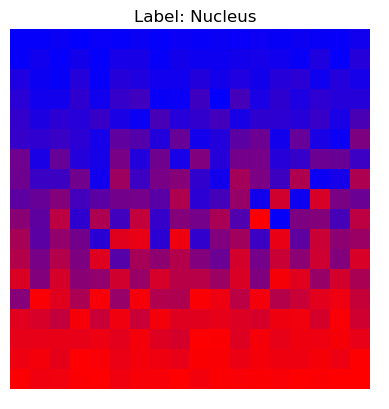

In [15]:
# Visualize the train data loader to see the transformed tensors
train_batch_images, train_batch_labels = next(iter(train_dataloader))

# Use first image in the batch
first_image_in_train_batch = train_batch_images[0]
image_to_plot = first_image_in_train_batch.permute(1, 2, 0).numpy().astype('uint8')
first_label_in_train_batch = train_batch_labels[0]

# Visualize the tensor as an image 
plt.imshow(image_to_plot)
plt.xticks([0, 3, 6, 9, 12, 18])
plt.yticks([0, 3, 6, 9, 12, 18])
plt.title(f"Label: {encoder.inverse_transform([first_label_in_train_batch.item()])[0]}")
plt.axis('off')

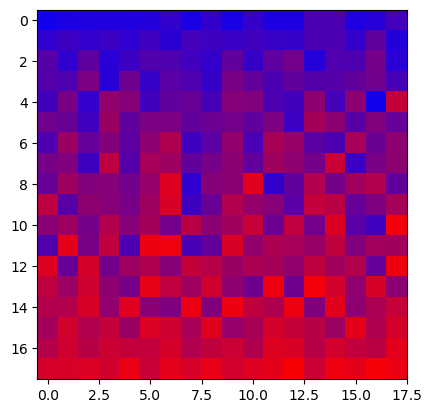

In [16]:
# Visualize the train data loader to see the transformed tensors
val_batch_images, val_batch_labels = next(iter(val_dataloader))

# Use first image in the batch
first_image_in_val_batch = val_batch_images[0]
image_to_plot = first_image_in_val_batch.permute(1, 2, 0).numpy().astype('uint8')
first_label_in_val_batch = val_batch_labels[0]

# Visualize the tensor as an image
plt.imshow(image_to_plot)

### Sanity check

In [17]:
# For recording the time and double check the sets before running
print(Time_Stamp)
print(f'Dataset: {Set}')
print(f'Image size: {Canvas_Size} x {Canvas_Size}')

2025_04202245
Dataset: Protein + mRNA
Image size: 18 x 18


### CustomNN class

In [18]:
class PixelPreservingNet(nn.Module):
    def __init__(self, in_channels=3):
        super(PixelPreservingNet, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, padding=1), 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.3)  
        )  # Shape remains same after padding

        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)  # Shape is reduced by half

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.3)  
        )  # Shape remains same after padding

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.3)  
        )  # Shape remains same after padding

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.3)  
        )  # Shape remains same after padding

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.3)  
        )

        # Fully connected layers
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling layer
        self.fc1 = nn.Sequential(
            nn.Linear(256, 512), #256->512
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256), #512->256
            nn.ReLU(),
            nn.Dropout(0.4)
        )

        # Output layer
        self.output = nn.Linear(256, 4) #256->4
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = self.conv4(x)
        x = self.pool(x)
        x = self.conv5(x)
        
        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.output(x)
        return x

### Training and testing epoch loop functions

In [19]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    total_loss, correct = 0.0, 0

    for X, y in dataloader:
        X = X.to(torch.float32).to(device)
        y = y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)
        softmax_probs = F.softmax(pred, dim=1)
        entropy = -torch.sum(softmax_probs * torch.log(softmax_probs + 1e-10), dim=1)
        penalty = torch.mean(entropy)
        total_loss_with_penalty = loss - 0.1 * penalty

        optimizer.zero_grad()
        total_loss_with_penalty.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (pred.argmax(1) == y).sum().item()
        current_lr = optimizer.param_groups[0]['lr']

    if LrScheduler:
        exp_lr_scheduler.step(metrics=total_loss)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / size

    return avg_loss, current_lr, accuracy
            
# Function for validating the model
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0.0, 0

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(torch.float32).to(device)
            y = y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).sum().item()

    test_loss /= num_batches
    accuracy = correct / size

    return test_loss, accuracy

### Confusion matrix, precision and recall calculation helper function

In [20]:
def calculate_precision_recall(dataloader, model):
    model.eval()
    y_pred, y_true = [], []

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(torch.float32).to(device)
            y = y.to(device)

            output = model(X)
            preds = output.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(y.cpu().numpy())

    cf_matrix = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall = recall_score(y_true, y_pred, average=None, zero_division=0)

    return cf_matrix, precision, recall

### F1 score helper function

In [21]:
# def calculate_f1_metrics(conf_matrix):
#     # True positives are the diagonal elements
#     tp = np.diag(conf_matrix)
#     # False positives are the sum of each column minus the diagonal element
#     fp = np.sum(conf_matrix, axis=0) - tp
#     # False negatives are the sum of each row minus the diagonal element
#     fn = np.sum(conf_matrix, axis=1) - tp
#     # True negatives are the sum of all elements minus the sum of the corresponding row and column plus tp
#     tn = conf_matrix.sum() - (fp + fn + tp)
    
#     # Precision, recall, and F1 score calculations
#     precision = tp / (tp + fp)
#     recall = tp / (tp + fn)
#     f1 = 2 * (precision * recall) / (precision + recall)
    
#     # Return macro-averaged F1 score (excluding NaNs caused by divisions by zero)
#     return np.nanmean(f1)

### Define loss functions and class weights 

In [22]:
# Focal loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        """
        :param gamma: focusing parameter (default=2.0)
        :param alpha: balance parameter, it can be a float or a tensor (default=None)
        :param reduction: specify the reduction to apply to the output: 'none' | 'mean' | 'sum' (default='mean')
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Compute cross-entropy loss
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # pt is the probability of the true class
        
        # Compute the focal loss
        F_loss = (1 - pt) ** self.gamma * BCE_loss
        
        # Apply class weighting (alpha) if provided
        if self.alpha is not None:
            alpha = self.alpha[targets]
            F_loss = alpha * F_loss
        
        # Apply the specified reduction
        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

In [23]:
# Loss function
# https://medium.com/@zergtant/use-weighted-loss-function-to-solve-imbalanced-data-classification-problems-749237f38b75

# def compute_class_weights(class_counts): # Inverse Frequency Normalized for extreme imbalance
#     class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)
#     return class_weights / class_weights.sum()

def compute_class_weights(class_counts): # inverse square root frequency for mild imbalance
    class_weights = 1.0 / torch.sqrt(torch.tensor(class_counts, dtype=torch.float))
    return class_weights / class_weights.sum()

# Given class counts
class_counts = [2401, 410, 1554, 1112]
LossWeights = compute_class_weights(class_counts)

if ApplyClassWeightToLoss:
    # Weights for each class for loss function
    LossWeights = LossWeights.to(device)
    
    if LossFunc_Name == 'CrossEntropy':
        loss_fn = nn.CrossEntropyLoss(label_smoothing=Label_Smoothing, weight=LossWeights)

    elif LossFunc_Name == 'Focal':
        loss_fn = FocalLoss(gamma=2, alpha=LossWeights, reduction='mean') 
        
else:
    if LossFunc_Name == 'CrossEntropy':
        loss_fn = nn.CrossEntropyLoss(label_smoothing=Label_Smoothing)
    
    elif LossFunc_Name == 'Focal':
        loss_fn = FocalLoss(gamma=2, alpha=None, reduction='mean')

### Define the model

In [24]:
# Define the model
model = PixelPreservingNet(in_channels=3)
model = model.to(dev)

# see the model architecture if desired
print(model)

PixelPreservingNet(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

### Define the optimizer

In [25]:
optimizer = torch.optim.AdamW(model.parameters(), lr=Learner_rate, betas=(0.9, 0.999), weight_decay=Weight_Decay)

### Define the learning rate scheduler

In [26]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
exp_lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

/opt/conda/envs/pytorch/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Run the model

In [27]:
# Set the seed for reproducibility
set_seed(Seed)

# Set up performance dataframes
PerformanceDF = pd.DataFrame(index=range(epochs), columns=['Epoch', 'TrainLoss', 'ValLoss', 'TrainAcc', 'ValAcc'])
PrecisionRecallDF = pd.DataFrame(columns=['Epoch', 'Class', 'Precision', 'Recall'])

print(f"{'Epoch':>5s}{'Train Loss':>13s}{'Val Loss':>11s}{'Train Accuracy':>17s}{'Val Accuracy':>15s}{'Current LR':>13s}\n")

current_lr = Learner_rate
best_val_loss = float('inf')  # initialize best val loss

for t in range(epochs):
    
    if t == 0:
        train_loss, train_accuracy = test_loop(train_dataloader, model, loss_fn)
        val_loss, val_accuracy = test_loop(val_dataloader, model, loss_fn)
        val_cf_matrix, precision, recall = calculate_precision_recall(val_dataloader, model)
    else:
        train_loss, current_lr, train_accuracy = train_loop(train_dataloader, model, loss_fn, optimizer)
        val_loss, val_accuracy = test_loop(val_dataloader, model, loss_fn)
        val_cf_matrix, precision, recall = calculate_precision_recall(val_dataloader, model)

    # Print metrics
    print(f"{t:>5d}{train_loss:>13.6f}{val_loss:>11.6f}{train_accuracy:>16.6f}{val_accuracy:>14.6f}{current_lr:>16.6f}")
    PerformanceDF.loc[t] = [t, train_loss, val_loss, train_accuracy, val_accuracy]
    
    for i in range(4):
        PrecisionRecallDF.loc[len(PrecisionRecallDF)] = [t, i, precision[i], recall[i]]

    # Save best model (lowest validation loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), Path(model_folder_path + f'best_model_{Run_Name}_{Time_Stamp}.pth'))

    # Save last model at final epoch
    if t + 1 == epochs:
        torch.save(model.state_dict(), Path(model_folder_path + f'last_model_{Run_Name}_{Time_Stamp}.pth'))

print("Done!")

Epoch   Train Loss   Val Loss   Train Accuracy   Val Accuracy   Current LR

    0     0.164811   0.167077        0.206865      0.180972        0.000100
    1     0.157173   0.160162        0.365894      0.418821        0.000100
    2     0.154990   0.159938        0.384700      0.422958        0.000100
    3     0.155061   0.159285        0.400402      0.436401        0.000100
    4     0.154451   0.159403        0.397298      0.431231        0.000100
    5     0.154660   0.159389        0.401315      0.423992        0.000100
    6     0.154790   0.159046        0.400219      0.425026        0.000100
    7     0.154168   0.159294        0.404784      0.432265        0.000100
    8     0.154372   0.159315        0.410809      0.429162        0.000100
    9     0.154212   0.159290        0.400767      0.427094        0.000100
   10     0.154231   0.158984        0.410261      0.434333        0.000100
   11     0.153958   0.159413        0.415008      0.410548        0.000100
   12     0.

# Testing

## Testing set prepration

### Dataloaders

In [28]:
# Read in the synthetic data
# Mertins 
#   proteome
M_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'M_PD_synthetic_kde_qttumor.csv'))
M_PD_synthetic.index = M_PD_synthetic.loc[:,'Index']
M_PD_synthetic = M_PD_synthetic.loc[:, M_PD_synthetic.columns!='Index']

#   transcriptome
M_MD_synthetic = pd.read_csv(Path(dataset_folder_path+'M_MD_synthetic_kde_qttumor.csv'))
M_MD_synthetic.index = M_MD_synthetic.loc[:,'gene_name']
M_MD_synthetic = M_MD_synthetic.loc[:, M_MD_synthetic.columns!='gene_name']


# LCSCC tumor
#   proteome
lung_tumor_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'lung_tumor_PD_synthetic_kde_qttumor.csv'))
lung_tumor_PD_synthetic.index = lung_tumor_PD_synthetic.loc[:,'Gene']
lung_tumor_PD_synthetic = lung_tumor_PD_synthetic.loc[:, lung_tumor_PD_synthetic.columns!='Gene']

#   transcriptome
lung_tumor_MD_synthetic = pd.read_csv(Path(dataset_folder_path+'lung_tumor_MD_synthetic_kde_qttumor.csv'))
lung_tumor_MD_synthetic.index = lung_tumor_MD_synthetic.loc[:,'gene_name']
lung_tumor_MD_synthetic = lung_tumor_MD_synthetic.loc[:, lung_tumor_MD_synthetic.columns!='gene_name']

# LCSCC NAT
#   proteome
lung_nat_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'lung_nat_PD_synthetic_kde_qttumor.csv'))
lung_nat_PD_synthetic.index = lung_nat_PD_synthetic.loc[:,'Gene']
lung_nat_PD_synthetic = lung_nat_PD_synthetic.loc[:, lung_nat_PD_synthetic.columns!='Gene']

#   transcriptome
lung_nat_MD_synthetic = pd.read_csv(Path(dataset_folder_path+'lung_nat_MD_synthetic_kde_qttumor.csv'))
lung_nat_MD_synthetic.index = lung_nat_MD_synthetic.loc[:,'gene_name']
lung_nat_MD_synthetic = lung_nat_MD_synthetic.loc[:, lung_nat_MD_synthetic.columns!='gene_name']

# Brain glioma
#   proteome
glioma_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'glioma_tumor_PD_synthetic_kde_qttumor.csv'))
glioma_PD_synthetic.index = glioma_PD_synthetic.loc[:,'gene_name']
glioma_PD_synthetic = glioma_PD_synthetic.loc[:, glioma_PD_synthetic.columns!='gene_name']

#   transcriptome
glioma_MD_synthetic = pd.read_csv(Path(dataset_folder_path+'glioma_tumor_MD_synthetic_kde_qttumor.csv'))
glioma_MD_synthetic.index = glioma_MD_synthetic.loc[:,'gene_name']
glioma_MD_synthetic = glioma_MD_synthetic.loc[:, glioma_MD_synthetic.columns!='gene_name']

In [29]:
# Read in the label
LD_mcf7 = pd.read_csv(Path(label_path+'markers_mcf7_all.txt'), sep='\t')
LD_mcf7.index = LD_mcf7.loc[:,'Protein']
LD_mcf7 = LD_mcf7.loc[:,LD_mcf7.columns!='Protein']

# Remove unclassified in LD
NotUnclassInd = LD_mcf7.loc[:,'Localization'] != 'Unclassified'
LD_mcf7 = LD_mcf7.loc[NotUnclassInd,:]

LD_h322 = pd.read_csv(Path(label_path+'markers_h322_all.txt'), sep='\t')
LD_h322.index = LD_h322.loc[:,'Protein']
LD_h322 = LD_h322.loc[:,LD_h322.columns!='Protein']

# Remove unclassified in LD
NotUnclassInd = LD_h322.loc[:,'Localization'] != 'Unclassified'
LD_h322 = LD_h322.loc[NotUnclassInd,:]

LD_u251 = pd.read_csv(Path(label_path+'markers_u251_all.txt'), sep='\t')
LD_u251.index = LD_u251.loc[:,'Protein']
LD_u251 = LD_u251.loc[:,LD_u251.columns!='Protein']

# Remove unclassified in LD
NotUnclassInd = LD_u251.loc[:,'Localization'] != 'Unclassified'
LD_u251 = LD_u251.loc[NotUnclassInd,:]


if Set == 'Protein + mRNA':
    M_LD = LD_mcf7.loc[M_PD_synthetic.index,:]
    lung_tumor_LD = LD_h322.loc[lung_tumor_PD_synthetic.index,:]
    lung_nat_LD = LD_h322.loc[lung_nat_PD_synthetic.index,:]
    glioma_LD = LD_u251.loc[glioma_PD_synthetic.index,:]

elif Set == 'Protein':
    M_LD = LD_mcf7.loc[M_PD_synthetic.index,:]
    lung_tumor_LD = LD_h322.loc[lung_tumor_PD_synthetic.index,:]
    lung_nat_LD = LD_h322.loc[lung_nat_PD_synthetic.index,:]
    glioma_LD = LD_u251.loc[glioma_PD_synthetic.index,:]

elif Set == 'mRNA':
    M_LD = LD_mcf7.loc[M_MD_synthetic.index,:]
    lung_tumor_LD = LD_h322.loc[lung_tumor_MD_synthetic.index,:]
    lung_nat_LD = LD_h322.loc[lung_nat_MD_synthetic.index,:]
    glioma_LD = LD_u251.loc[glioma_MD_synthetic.index,:]

In [30]:
# Count labels and report the count and percentage
M_LD_count = M_LD.value_counts()
lung_tumor_LD_count = lung_tumor_LD.value_counts()
lung_nat_LD_count = lung_nat_LD.value_counts()
glioma_LD_count = glioma_LD.value_counts()

# transform the counts into one dataframe with columns as study name and rows as labels
M_LD_count = M_LD_count.to_frame().T
M_LD_count.index = ['Mertins']
lung_tumor_LD_count = lung_tumor_LD_count.to_frame().T
lung_tumor_LD_count.index = ['LCSCC Tumor']
lung_nat_LD_count = lung_nat_LD_count.to_frame().T
lung_nat_LD_count.index = ['LCSCC NAT']
glioma_LD_count = glioma_LD_count.to_frame().T
glioma_LD_count.index = ['Glioma']
LD_count = pd.concat([M_LD_count, lung_tumor_LD_count, lung_nat_LD_count, glioma_LD_count], axis=0)
LD_count = LD_count.fillna(0)
LD_count = LD_count.astype(int)
LD_count = LD_count.T
LD_count = LD_count.rename_axis('Localization').reset_index()
LD_count

,Localization,Mertins,LCSCC Tumor,LCSCC NAT,Glioma
0,Cytosol,2564,3015,3028,2716
1,Nucleus,1561,1812,1813,1680
2,Secretory,967,1490,1493,1465
3,Mitochondria,448,497,497,400


In [31]:
# Set the seed for reproducibility
set_seed(Seed)

# Create a LabelEncoder
encoder = LabelEncoder()

# Fit the encoder and transform the labels to integers from LD, the label df
M_labels = torch.tensor(encoder.fit_transform(M_LD.values.ravel()))
lung_tumor_LD = torch.tensor(encoder.fit_transform(lung_tumor_LD.values.ravel()))
lung_nat_LD = torch.tensor(encoder.fit_transform(lung_nat_LD.values.ravel()))
glioma_LD = torch.tensor(encoder.fit_transform(glioma_LD.values.ravel()))

# Check Dataset argument to determine which dataset to use
if Set == 'Protein':
    M_test_dataset = MyDataset(Set, M_PD_synthetic, M_PD_synthetic, M_labels, transform=None)
    lung_tumor_test_dataset = MyDataset(Set, lung_tumor_PD_synthetic, lung_tumor_PD_synthetic, lung_tumor_LD, transform=None)
    lung_nat_test_dataset = MyDataset(Set, lung_nat_PD_synthetic, lung_nat_PD_synthetic, lung_nat_LD, transform=None)
    glioma_test_dataset = MyDataset(Set, glioma_PD_synthetic, glioma_PD_synthetic, glioma_LD, transform=None)
    print('Protein dataset loaded')
elif Set == 'mRNA':
    M_test_dataset = MyDataset(Set, M_MD_synthetic, M_MD_synthetic, M_labels, transform=None)
    lung_tumor_test_dataset = MyDataset(Set, lung_tumor_MD_synthetic, lung_tumor_MD_synthetic, lung_tumor_LD, transform=None)
    lung_nat_test_dataset = MyDataset(Set, lung_nat_MD_synthetic, lung_nat_MD_synthetic, lung_nat_LD, transform=None)
    glioma_test_dataset = MyDataset(Set, glioma_MD_synthetic, glioma_MD_synthetic, glioma_LD, transform=None)
    print('mRNA dataset loaded')
elif Set == 'Protein + mRNA':
    M_test_dataset = MyDataset(Set, M_PD_synthetic, M_MD_synthetic, M_labels, transform=None)
    lung_tumor_test_dataset = MyDataset(Set, lung_tumor_PD_synthetic, lung_tumor_MD_synthetic, lung_tumor_LD, transform=None)
    lung_nat_test_dataset = MyDataset(Set, lung_nat_PD_synthetic, lung_nat_MD_synthetic, lung_nat_LD, transform=None)
    glioma_test_dataset = MyDataset(Set, glioma_PD_synthetic, glioma_MD_synthetic, glioma_LD, transform=None)
    print('Protein + mRNA dataset loaded')
else:
    raise ValueError("Set must be 'Protein', 'mRNA' or 'Protein + mRNA'")

# Create the dataloaders
M_test_dataloader = DataLoader(M_test_dataset, batch_size=batch, shuffle=False)
lung_tumor_test_dataloader = DataLoader(lung_tumor_test_dataset, batch_size=batch, shuffle=False)
lung_nat_test_dataloader = DataLoader(lung_nat_test_dataset, batch_size=batch, shuffle=False)
glioma_test_dataloader = DataLoader(glioma_test_dataset, batch_size=batch, shuffle=False)

Protein + mRNA dataset loaded


### Re-define loss function

In [32]:
if LossFunc_Name == 'CrossEntropy':
    loss_fn = nn.CrossEntropyLoss(label_smoothing=Label_Smoothing)

elif LossFunc_Name == 'Focal':
    loss_fn = FocalLoss(gamma=2, alpha=None, reduction='mean')

## Metrics

### Fig 1: training and validation loss

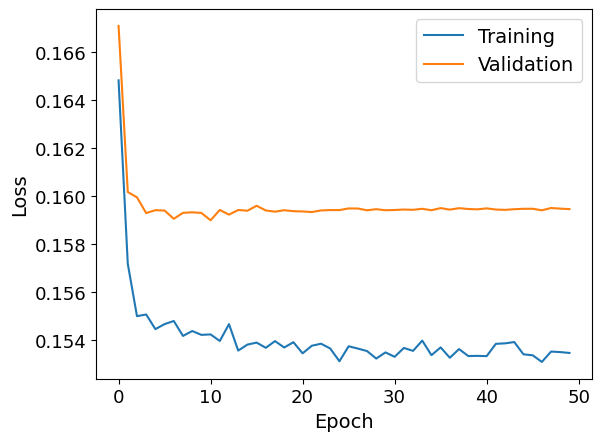

In [33]:
# Graph loss for training and validation
figure1 = plt.gcf()
plt.plot(PerformanceDF['Epoch'], PerformanceDF['TrainLoss'])
plt.plot(PerformanceDF['Epoch'], PerformanceDF['ValLoss'])
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.legend(['Training', 'Validation'], fontsize=14)

### Fig 2: training and validation accuracy

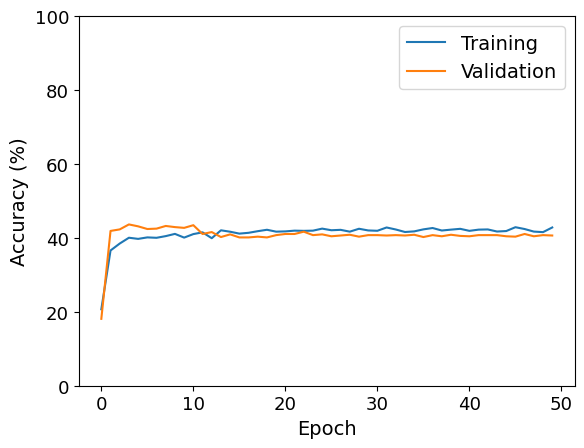

In [34]:
# Graph accuracy for training and validation
figure2 = plt.gcf()
plt.plot(PerformanceDF['Epoch'], (PerformanceDF['TrainAcc'])*100)
plt.plot(PerformanceDF['Epoch'], (PerformanceDF['ValAcc'])*100)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.ylim([0,100])
plt.legend(['Training', 'Validation'], fontsize=14)

### Fig 3: validation confusion matrix by best model

In [35]:
# load the model
last_model = PixelPreservingNet(in_channels=3)
last_model.load_state_dict(torch.load(Path(model_folder_path + f'last_model_{Run_Name}_{Time_Stamp}.pth'), weights_only=True))
last_model.to(dev)

PixelPreservingNet(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [36]:
# # Evalulate validation set (accuracy, F1, confusion matrix)
# last_model.eval()
# with torch.no_grad():
#     # Accuracy
#     val_loss, val_accuracy = test_loop(val_dataloader, last_model, loss_fn)
#     print(f"Validation accuracy by best model: {round(val_accuracy, 3)}")
    
#     # Confusion matrix, precision, recall
#     val_cf_matrix, val_precision, val_recall = calculate_precision_recall(val_dataloader, last_model)
#     print(f'Validation precision by best model: Cytosol {round(val_precision[0],3)}, Mitochondrial {round(val_precision[1],3)}, Nuclear {round(val_precision[2],3)}, Secretory {round(val_precision[3],3)}')
#     print(f'Validation recall by best model: Cytosol {round(val_recall[0],3)}, Mitochondrial {round(val_recall[1],3)}, Nuclear {round(val_recall[2],3)}, Secretory {round(val_recall[3],3)}')

#     # F1
#     val_f1 = calculate_f1_metrics(val_cf_matrix)
#     print(f'Validation F1 score by best model is {round(val_f1, 3)}')

# # Confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=val_cf_matrix, display_labels=['Cytosolic', 'Mitochondrial', 'Nuclear', 'Secretory'])
# disp.plot(cmap=plt.cm.Blues)

### Fig 4: testing confusion matrics by best model

In [37]:
# # Slient warnings
# warnings.filterwarnings("ignore")

# # Evalulate test set (accuracy, precision, recall, F1)
# last_model.eval()
# with torch.no_grad():
#     # Mertins test set
#     # Accuracy, precision, recall
#     M_test_loss, M_test_accuracy = test_loop(M_test_dataloader, last_model, loss_fn)
#     M_test_cf_matrix, M_precision, M_recall = calculate_precision_recall(M_test_dataloader, last_model)
#     print(f"Mertins testing accuracy by best model: {round(M_test_accuracy, 3)}")
#     if M_test_accuracy == 0:
#         pass
#     else:
#         print(f'Mertins testing precision by best model: Cytosol {round(M_precision[0],3)}, Mitochondrial {round(M_precision[1],3)}, Nuclear {round(M_precision[2],3)}, Secretory {round(M_precision[3],3)}')
#         print(f'Mertins testing recall by best model: Cytosol {round(M_recall[0],3)}, Mitochondrial {round(M_recall[1],3)}, Nuclear {round(M_recall[2],3)}, Secretory {round(M_recall[3],3)}')

#     # F1
#     M_test_f1 = calculate_f1_metrics(M_test_cf_matrix)
#     print(f'Mertins testing F1 score by best model is {round(M_test_f1, 3)}')


# # Display the confusion matrices side by side
# if M_test_accuracy == 0:
#     pass
# else:
#     disp_M = ConfusionMatrixDisplay(confusion_matrix=M_test_cf_matrix, display_labels=['Cytosolic', 'Mitochondrial', 'Nuclear', 'Secretory'])
#     disp_M.plot(cmap=plt.cm.Blues)


In [38]:
# # Slient warnings
# warnings.filterwarnings("ignore")

# # Evalulate test set (accuracy, precision, recall, F1)
# last_model.eval()
# with torch.no_grad():
#     # Lung tumor test set
#     #   Accuracy, precision, recall
#     lung_tumor_test_loss, lung_tumor_test_accuracy = test_loop(lung_tumor_test_dataloader, last_model, loss_fn)
#     lung_tumor_test_cf_matrix, lung_tumor_precision, lung_tumor_recall = calculate_precision_recall(lung_tumor_test_dataloader, last_model)
#     print(f"Lung tumor testing accuracy by best model: {round(lung_tumor_test_accuracy, 3)}")
#     if lung_tumor_test_accuracy == 0:
#         pass
#     else:
#         print(f'Lung tumor testing precision by best model: Cytosol {round(lung_tumor_precision[0],3)}, Mitochondrial {round(lung_tumor_precision[1],3)}, Nuclear {round(lung_tumor_precision[2],3)}, Secretory {round(lung_tumor_precision[3],3)}')
#         print(f'Lung tumor testing recall by best model: Cytosol {round(lung_tumor_recall[0],3)}, Mitochondrial {round(lung_tumor_recall[1],3)}, Nuclear {round(lung_tumor_recall[2],3)}, Secretory {round(lung_tumor_recall[3],3)}')
#     #   F1
#     lung_tumor_test_f1 = calculate_f1_metrics(lung_tumor_test_cf_matrix)
#     print(f'Lung tumor testing F1 score by best model is {round(lung_tumor_test_f1, 3)}')

#     # Lung NAT test set
#     #   Accuracy, precision, recall
#     lung_nat_test_loss, lung_nat_test_accuracy = test_loop(lung_nat_test_dataloader, last_model, loss_fn)
#     lung_nat_test_cf_matrix, lung_nat_precision, lung_nat_recall = calculate_precision_recall(lung_nat_test_dataloader, last_model)
#     print(f"Lung NAT testing accuracy by best model: {round(lung_nat_test_accuracy, 3)}")
#     if lung_nat_test_accuracy == 0:
#         pass
#     else:
#         print(f'Lung NAT testing precision by best model: Cytosol {round(lung_nat_precision[0],3)}, Mitochondrial {round(lung_nat_precision[1],3)}, Nuclear {round(lung_nat_precision[2],3)}, Secretory {round(lung_nat_precision[3],3)}')
#         print(f'Lung NAT testing recall by best model: Cytosol {round(lung_nat_recall[0],3)}, Mitochondrial {round(lung_nat_recall[1],3)}, Nuclear {round(lung_nat_recall[2],3)}, Secretory {round(lung_nat_recall[3],3)}')
#     #   F1
#     lung_nat_test_f1 = calculate_f1_metrics(lung_nat_test_cf_matrix)
#     print(f'Lung NAT testing F1 score by best model is {round(lung_nat_test_f1, 3)}')

#     # Glioma test set
#     #   Accuracy, precision, recall
#     glioma_test_loss, glioma_test_accuracy = test_loop(glioma_test_dataloader, last_model, loss_fn)
#     glioma_test_cf_matrix, glioma_precision, glioma_recall = calculate_precision_recall(glioma_test_dataloader, last_model)
#     print(f"Glioma testing accuracy by best model: {round(glioma_test_accuracy, 3)}")
#     if glioma_test_accuracy == 0:
#         pass
#     else:
#         print(f'Glioma testing precision by best model: Cytosol {round(glioma_precision[0],3)}, Mitochondrial {round(glioma_precision[1],3)}, Nuclear {round(glioma_precision[2],3)}, Secretory {round(glioma_precision[3],3)}')
#         print(f'Glioma testing recall by best model: Cytosol {round(glioma_recall[0],3)}, Mitochondrial {round(glioma_recall[1],3)}, Nuclear {round(glioma_recall[2],3)}, Secretory {round(glioma_recall[3],3)}')
#     #   F1
#     glioma_test_f1 = calculate_f1_metrics(glioma_test_cf_matrix)
#     print(f'Glioma testing F1 score by best model is {round(glioma_test_f1, 3)}')


# # Display the confusion matrices side by side
# if lung_tumor_test_accuracy == 0:
#     pass
# else:
#     disp_lung_tumor = ConfusionMatrixDisplay(confusion_matrix=lung_tumor_test_cf_matrix, display_labels=['Cytosolic', 'Mitochondrial', 'Nuclear', 'Secretory'])
#     disp_lung_tumor.plot(cmap=plt.cm.Blues)
    
# if lung_nat_test_accuracy == 0:
#     pass
# else:
#     disp_lung_nat = ConfusionMatrixDisplay(confusion_matrix=lung_nat_test_cf_matrix, display_labels=['Cytosolic', 'Mitochondrial', 'Nuclear', 'Secretory'])
#     disp_lung_nat.plot(cmap=plt.cm.Blues)

# if glioma_test_accuracy == 0:
#     pass
# else:
#     disp_glioma = ConfusionMatrixDisplay(confusion_matrix=glioma_test_cf_matrix, display_labels=['Cytosolic', 'Mitochondrial', 'Nuclear', 'Secretory'])
#     disp_glioma.plot(cmap=plt.cm.Blues)

In [39]:
# Function to calculate the precision and recall
def calculate_metrics(dataloader, model):
    y_pred = []
    y_true = []
    
    model.eval()
    with torch.no_grad():
        
        # iterate over validation data
        for X, y in dataloader:
            
            X = X.to(torch.float32)
            X = X.to(device)
            output = model(X)  # Feed Network

            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            y_pred.extend(output)  # Save Prediction

            labels = y.cpu().numpy()
            y_true.extend(labels)  # Save Truth

    # Calculate confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)

    # Calculate precision and recall for each class
    precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall = recall_score(y_true, y_pred, average=None, zero_division=0)
    #macro_f1 = f1_score(y_true, y_pred, average='macro')
    #mcc = matthews_corrcoef(y_true, y_pred)

    return cf_matrix, precision, recall#, macro_f1, mcc


# make a function that visualize 5 confusion matrices from 5 data loaders, and stack them into one figure, 3 by 2
def plot_confusion_matrices(cf_matrices, labels, title):
    fig, axes = plt.subplots(2, 3, figsize=(10, 6))
    axes = axes.flatten()
    
    for i, cf_matrix in enumerate(cf_matrices):
        sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=labels, yticklabels=labels, ax=axes[i])
        #axes[i].set_xlabel('Predicted')
        #axes[i].set_ylabel('True')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
        axes[i].set_title(title[i])
    
    # remove the last empty subplot
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    # set an overall x and y label for the entire figure
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make space for the title
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    fig.text(0.5, 0, 'Predicted', ha='center', fontdict={'size': 16})
    fig.text(0, 0.5, 'True', va='center', rotation='vertical', fontdict={'size': 16})

    #fig.xlabel('Predicted')
    #fig.ylabel('True')
    plt.tight_layout()
    plt.show()

label_to_int = {
    'Cytosol': 0,
    'Mitochondria': 1,
    'Nucleus': 2,
    'Secretory': 3
}
int_to_label = {v: k for k, v in label_to_int.items()}

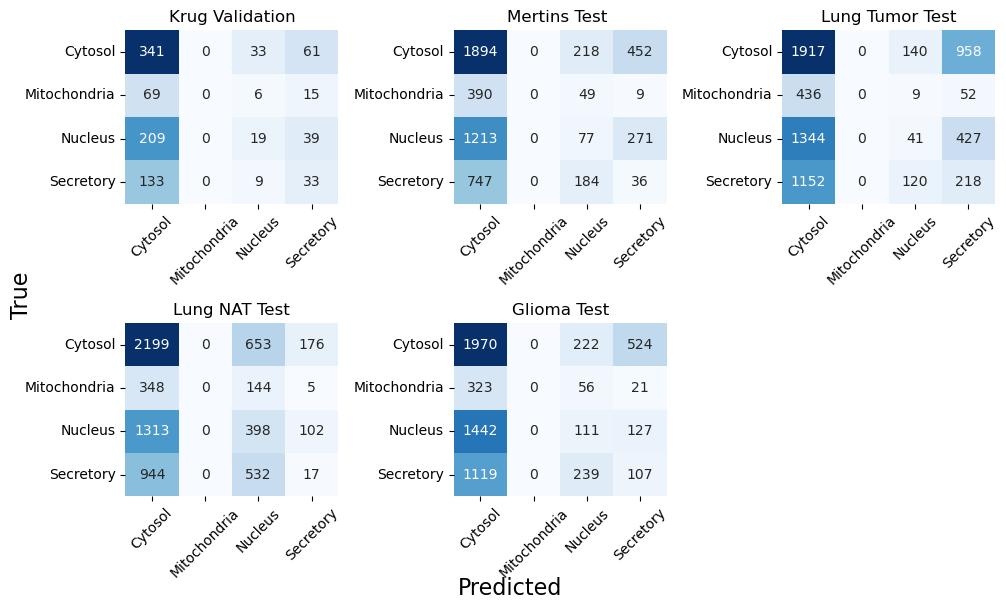

In [40]:
# Get the confusion matrix and precision and recall for the validation loader and all test loaders
cf_matrix_val, precision_val, recall_val= calculate_metrics(val_dataloader, last_model)
cf_matrix_M, precision_M, recall_M = calculate_metrics(M_test_dataloader, last_model)
cf_matrix_lung_tumor, precision_lung_tumor, recall_lung_tumor= calculate_metrics(lung_tumor_test_dataloader, last_model)
cf_matrix_lung_nat, precision_lung_nat, recall_lung_nat= calculate_metrics(lung_nat_test_dataloader, last_model)
cf_matrix_glioma, precision_glioma, recall_glioma = calculate_metrics(glioma_test_dataloader, last_model)

# Put them into a list
cf_matrices = [cf_matrix_val, cf_matrix_M, cf_matrix_lung_tumor, cf_matrix_lung_nat, cf_matrix_glioma]
titles = ['Krug Validation', 'Mertins Test ', 'Lung Tumor Test', 'Lung NAT Test', 'Glioma Test']

# Plot the confusion matrices
plot_confusion_matrices(cf_matrices, labels=int_to_label.values(), title=titles)


### Fig 5: Precision and recall of validation and testing

In [41]:
def compute_bootstrap_ci(dataloader, num_iterations=10000, confidence_percentile=95):
    """
    Computes precision, recall, and F1-score confidence intervals using bootstrapping.

    Parameters:
    - dataloader: DataLoader containing the dataset (can be any dataset, not specifically validation)
    - num_iterations: Number of bootstrap iterations (default: 10000)
    - confidence_percentile: The percentile for confidence intervals (default: 95)

    Returns:
    - f1_final_array: The confidence interval values for F1-score
    """
    
    # Initialize a Counter to store class counts in the dataset
    class_counts = Counter()

    # Iterate over the DataLoader to count occurrences of each class
    for _, labels in dataloader:
        class_counts.update(labels.numpy())

    # Sort the class distribution and convert counts to percentages
    class_names = ['Cytosolic', 'Mitochondrial', 'Nuclear', 'Secretory']
    total_samples = len(dataloader.dataset)

    class_distribution = [(class_names[label], round(count / total_samples * 10000)) for label, count in sorted(class_counts.items())]

    # Create a vector of 10,000 true labels based on the class distribution
    true_labels_vector = np.array([class_name for class_name, count in class_distribution for _ in range(count)])
    random.shuffle(true_labels_vector)

    # Sample predicted labels randomly from true_labels_vector
    pred_labels_vector = np.random.choice(true_labels_vector, size=10000, replace=True)

    # Ensure both vectors have the same shape
    assert true_labels_vector.shape == pred_labels_vector.shape

    # Initialize arrays for storing precision, recall, and F1 scores
    precision_array = np.zeros((len(class_counts), num_iterations))
    recall_array = np.zeros((len(class_counts), num_iterations))
    f1_array = np.zeros((len(class_counts), num_iterations))

    # Perform bootstrapping by shuffling labels and computing metrics
    for i in range(num_iterations):
        # Shuffle the true and predicted labels independently
        #shuffled_true = np.random.permutation(true_labels_vector)
        shuffled_pred = np.random.permutation(pred_labels_vector)

        # Compute precision and recall for each class
        precision = precision_score(shuffled_true, shuffled_pred, average=None, zero_division=0)
        recall = recall_score(shuffled_true, shuffled_pred, average=None, zero_division=0)

        # Compute F1-score, handling division by zero safely
        f1 = np.where((precision + recall) == 0, 0, 
                      2 * (precision * recall) / (precision + recall))

        # Store results in the respective arrays
        precision_array[:, i] = precision
        recall_array[:, i] = recall
        f1_array[:, i] = f1

    # Sort each row in the arrays from smallest to largest
    f1_array_sorted = np.sort(f1_array, axis=1)

    # Extract the confidence percentile value (e.g., 95th percentile)
    ci_index = int(num_iterations * (confidence_percentile / 100)) - 1  # Zero-based index

    f1_final_array = f1_array_sorted[:, ci_index]

    return f1_final_array

In [42]:
# val_ci_f1_array = compute_bootstrap_ci(val_dataloader, num_iterations=10000, confidence_percentile=95)
# M_ci_f1_array = compute_bootstrap_ci(M_test_dataloader, num_iterations=10000, confidence_percentile=95)
# JM_ci_f1_array = compute_bootstrap_ci(JM_test_dataloader, num_iterations=10000, confidence_percentile=95)

In [43]:
val_ci_f1_array = np.array([0.43314056, 0.09879518, 0.30857335, 0.20966921])

In [44]:
M_ci_f1_array = np.array([0.45134342, 0.0976801 , 0.29827316, 0.20153805])

In [45]:
JM_ci_f1_array = np.array([0.44705614, 0.09885473, 0.29755245, 0.20585948])

NameError: name 'final_epoch' is not defined

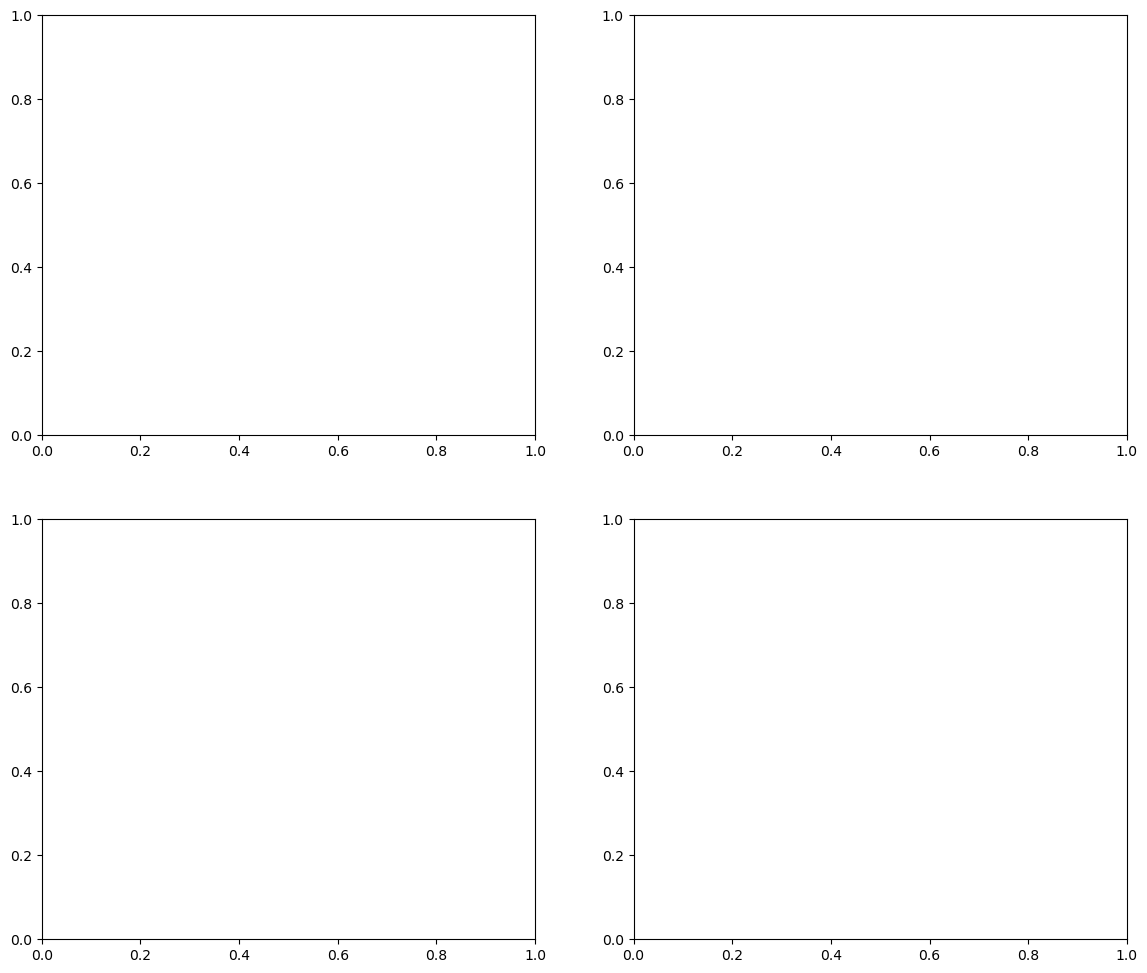

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()
compartment_class = ['Cytosolic', 'Mitochondria', 'Nuclear', 'Secretory']
colormaps = [cm.Blues, cm.Oranges, cm.Greens, cm.Purples]

# Function to filter improvement epochs using precision as the guide
def filter_improvement_epochs(df):
    improved_epochs = []
    for class_label in df['Class'].unique():
        class_df = df[df['Class'] == class_label].copy()
        class_df = class_df.sort_values(by='Epoch')
        max_precision = float('-inf')
        
        for _, row in class_df.iterrows():
            if row['Precision'] >= max_precision:
                max_precision = row['Precision']
                improved_epochs.append(row)
    
    # Ensure starting (0) and ending (last) epochs are included
    start_epoch = df[df['Epoch'] == 0]
    final_epoch_df = df[df['Epoch'] == final_epoch]
    last_epoch = df[df['Epoch'] == df['Epoch'].max()]
    
    return pd.concat([start_epoch, pd.DataFrame(improved_epochs), final_epoch_df, last_epoch]).drop_duplicates()

# Get improvement epochs based on precision
improved_epochs_df = filter_improvement_epochs(PrecisionRecallDF)

for i, f1_score in enumerate(val_ci_f1_array):
    # Select the subplot
    ax = axes[i]

    # Filter the metrics for the current class
    class_metrics = improved_epochs_df[improved_epochs_df['Class'] == i]
    # Normalize epoch for color mapping
    norm = plt.Normalize(class_metrics['Epoch'].min(), class_metrics['Epoch'].max())

    # Scatter plot with gradient color based on epoch
    for idx, row in class_metrics.iterrows():
        color = colormaps[i](norm(row['Epoch']))
        edge_color = colormaps[i](0.8)
        ax.scatter(row['Recall'], row['Precision'], s=100, color=color, edgecolors=edge_color, linewidths=1)

    # Connect the dots with colored lines
    ax.plot(class_metrics['Recall'], class_metrics['Precision'], color=colormaps[i](0.5), linewidth=2)

    # Plot the F1 score curve
    x_left = np.linspace(0, (f1_score / 2), 10000)
    x_right = np.linspace((f1_score / 2), 1, 10000)
    y_right = f1_score * x_right / (2 * x_right - f1_score)
    ax.plot(x_right, y_right, color=colormaps[i](0.5), linestyle='--', linewidth=2)
    # Fill the area on the left of the curve
    ax.fill_between(x_left, 0, 1, color=colormaps[i](0.5), alpha=0.3)
    ax.fill_between(x_right, 0, y_right, color=colormaps[i](0.5), alpha=0.3)

    # Add in a scatter dot to label the precision and recall of testing set
    ax.scatter(M_recall[i], M_precision[i], s=100, color='red', edgecolors='red', linewidths=1, marker='s')
    ax.scatter(lung_tumor_recall[i], lung_tumor_precision[i], s=100, color='purple', edgecolors='purple', linewidths=1, marker='s')
    ax.scatter(lung_nat_recall[i], lung_nat_precision[i], s=100, color='orange', edgecolors='orange', linewidths=1, marker='s')
    ax.scatter(glioma_recall[i], glioma_precision[i], s=100, color='green', edgecolors='green', linewidths=1, marker='s')

    # Aesthetics
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_title(compartment_class[i], fontsize=16)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('Recall (Sensitivity)', fontsize=14)
    ax.set_ylabel('Precision (Positive Predictive Value)', fontsize=14)
    ax.grid(True)

    # Create custom legend handles
    mertins_handle = mlines.Line2D([], [], color='red', marker='s', linestyle='None', markersize=10, label='Mertins test set')
    lung_tumor_handle = mlines.Line2D([], [], color='purple', marker='s', linestyle='None', markersize=10, label='LSCC Tumor test set')
    lung_nat_handle = mlines.Line2D([], [], color='orange', marker='s', linestyle='None', markersize=10, label='LSCC NAT test set')
    glioma_handle = mlines.Line2D([], [], color='green', marker='s', linestyle='None', markersize=10, label='Glioma test set')

    # Add the legend to the plot
    ax.legend(handles=[mertins_handle, lung_tumor_handle, lung_nat_handle, glioma_handle], loc='upper right', fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
# # export dataframes
# PerformanceDF.to_excel(Path(performance_folder_path + f'PerformanceDF_{Time_Stamp}.xlsx'), index=False)
# PrecisionRecallDF.to_excel(Path(performance_folder_path + f'PrecisionRecallDF_{Time_Stamp}.xlsx'), index=False)